In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV #hyperparameter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold #hyperparameter lr&lda

#Import Sampler libraries
from imblearn.over_sampling import SMOTE #resampling
from imblearn.under_sampling import RandomUnderSampler #resampling
from imblearn.pipeline import Pipeline as imbPipeline #resampling

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

gender   age  hypertension  heart_disease smoking_history   bmi  \
0  Female 80.00             0              1           never 25.19   
1  Female 54.00             0              0         No Info 27.32   
2    Male 28.00             0              0           never 27.32   
3  Female 36.00             0              0         current 23.45   
4    Male 76.00             1              1         current 20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0         6.60                  140         0  
1         6.60                   80         0  
2         5.70                  158         0  
3         5.00                  155         0  
4         4.80                  155         0

In [3]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)
df = df.drop_duplicates()

# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

number of duplicate rows:  (3854, 9)


In [4]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 2 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [5]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [6]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [7]:
df.describe().style.format("{:.2f}")

In [8]:
df = df.drop("HbA1c_level", axis = 1)
df.head()

gender   age  hypertension  heart_disease smoking_history   bmi  \
0  Female 80.00             0              1           never 25.19   
1  Female 54.00             0              0         No Info 27.32   
2    Male 28.00             0              0           never 27.32   
3  Female 36.00             0              0         current 23.45   
4    Male 76.00             1              1         current 20.14   

   blood_glucose_level  diabetes  
0                  140         0  
1                   80         0  
2                  158         0  
3                  155         0  
4                  155         0

In [9]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 1
    elif smoking_status == 'current':
        return 2
    elif smoking_status in ['ever', 'former', 'not current']:
        return 3

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

1    67276
3    19655
2     9197
Name: smoking_history, dtype: int64


In [10]:
# Define a function to map the existing categories to new ones
def recategorize_gender(gender_status):
    if gender_status == 'Male':
        return 1
    elif gender_status == 'Female':
        return 0

# Apply the function to the 'smoking_history' column
df['gender'] = df['gender'].apply(recategorize_gender)

# Check the new value counts
print(df['gender'].value_counts())

0    56161
1    39967
Name: gender, dtype: int64


In [11]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df["blood_glucose_level"]
df["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df = df.drop("blood_glucose_level", axis=1)
df.head(5)

gender   age  hypertension  heart_disease  smoking_history   bmi  diabetes  \
0       0 80.00             0              1                1 25.19         0   
1       0 54.00             0              0                1 27.32         0   
2       1 28.00             0              0                1 27.32         0   
3       0 36.00             0              0                2 23.45         0   
4       1 76.00             1              1                2 20.14         0   

   voltage_ratio  
0          56.24  
1          72.80  
2          51.27  
3          52.10  
4          52.10

In [12]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'voltage_ratio', 'diabetes']]

print(df)

       gender   age  hypertension  heart_disease  smoking_history   bmi  \
0           0 80.00             0              1                1 25.19   
1           0 54.00             0              0                1 27.32   
2           1 28.00             0              0                1 27.32   
3           0 36.00             0              0                2 23.45   
4           1 76.00             1              1                2 20.14   
...       ...   ...           ...            ...              ...   ...   
99994       0 36.00             0              0                1 24.60   
99996       0  2.00             0              0                1 17.37   
99997       1 66.00             0              0                3 27.83   
99998       0 24.00             0              0                1 35.42   
99999       0 57.00             0              0                2 22.43   

       voltage_ratio  diabetes  
0              56.24         0  
1              72.80         0  


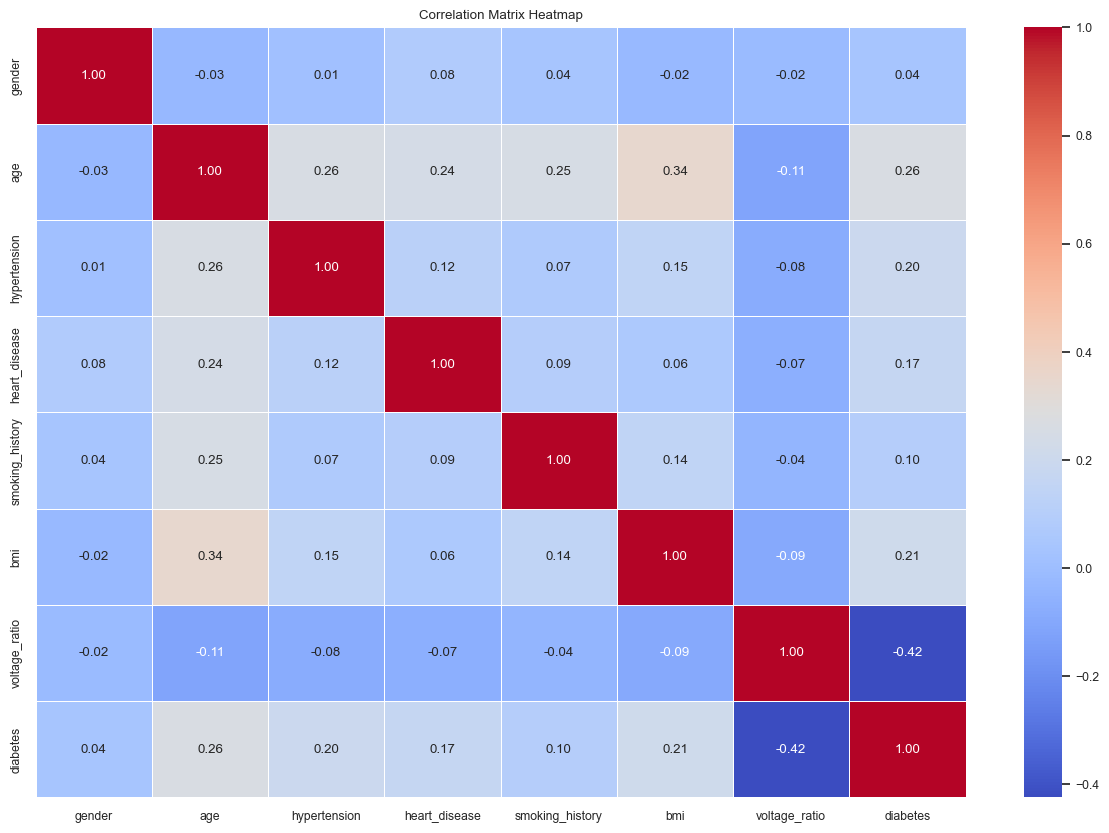

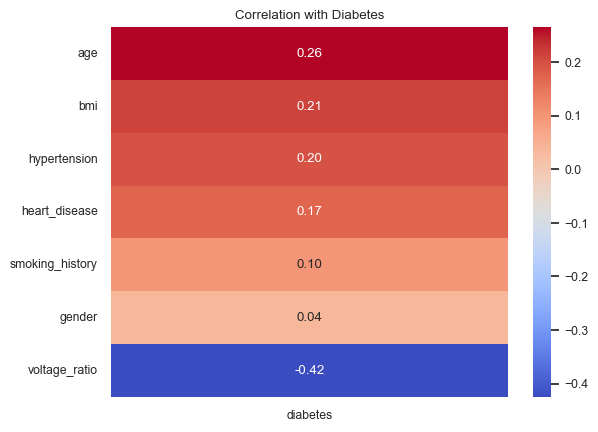

In [28]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [62]:
df_new = df.copy()

#Menghitung sampel sebelum resampling data
diabetes_1 = len(df_new['diabetes'][df_new['diabetes'] == 1])  # Filter for rows where any value is 1
diabetes_0 = len(df_new['diabetes'][df_new['diabetes'] == 0]) # Filter for rows where any value is 1
print(diabetes_0)
print(diabetes_1)

87646
8482


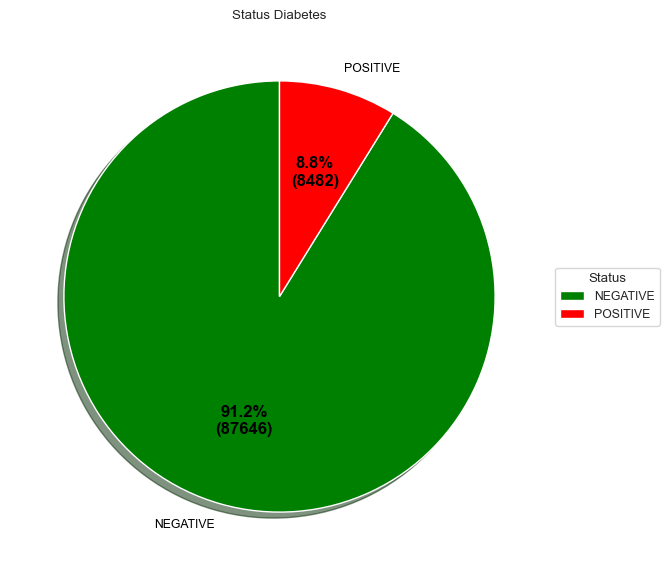

In [63]:
# Creating dataset
cars = ['NEGATIVE', 'POSITIVE']
 
data = [diabetes_0, diabetes_1]
 
 
# Creating color parameters
colors = ("green", "red")
 
# Wedge properties
wp = {'linewidth': 1, 'edgecolor': "white"}
 
# Creating autocpt arguments
 
 
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
 
# Creating plot
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  labels=cars,
                                  shadow=True,
                                  colors=colors,
                                  startangle=90,
                                  wedgeprops=wp,
                                  textprops=dict(color="black"))
 
# Adding legend
ax.legend(wedges, cars,
          title="Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
 
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Status Diabetes")
 
# show plot
plt.show()

In [86]:
# Split data into features and target variable
X = df_new.drop('diabetes', axis=1)
y = df_new['diabetes']

In [87]:
# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

In [88]:
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [89]:
diabetes_1 = len(y[y == 1])  # Filter for rows where any value is 1
diabetes_0 = len(y[y == 0]) # Filter for rows where any value is 0
print(diabetes_0)
print(diabetes_1)

35058
17529


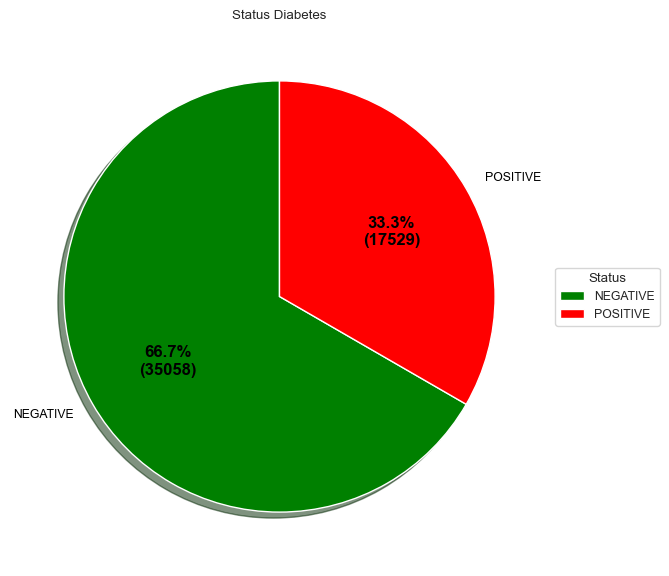

In [90]:
# Creating dataset
cars = ['NEGATIVE', 'POSITIVE']
 
data = [diabetes_0, diabetes_1]
 
 
# Creating color parameters
colors = ("green", "red")
 
# Wedge properties
wp = {'linewidth': 1, 'edgecolor': "white"}
 
# Creating autocpt arguments
 
 
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
 
# Creating plot
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  labels=cars,
                                  shadow=True,
                                  colors=colors,
                                  startangle=90,
                                  wedgeprops=wp,
                                  textprops=dict(color="black"))
 
# Adding legend
ax.legend(wedges, cars,
          title="Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
 
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Status Diabetes")
 
# show plot
plt.show()

**GINI IMPORTANCE**

In [91]:
attribute_names =  list(X[:-1])
class_name = 'diabetes'

def gini_impurity (value_counts):
    n = value_counts.sum()
    p_sum = 0
    for key in value_counts.keys():
        p_sum = p_sum  +  (value_counts[key] / n ) * (value_counts[key] / n )
    gini = 1 - p_sum
    return gini

class_value_counts = y.value_counts()
print(f'Number of samples in each class is:\n{class_value_counts}')

gini_class = gini_impurity(class_value_counts)
print(f'\nGini Impurity of the class is {gini_class:.3f}')

Number of samples in each class is:
0    35058
1    17529
Name: diabetes, dtype: int64

Gini Impurity of the class is 0.444


In [92]:
def gini_split_a(attribute_name):
    attribute_values = X[attribute_name].value_counts()
    gini_A = 0
    for key in attribute_values.keys():
        df_k = y[X[attribute_name] == key].value_counts()
        n_k = attribute_values[key]
        n = X.shape[0]
        gini_A = gini_A + (( n_k / n) * gini_impurity(df_k))
    return gini_A

gini_attiribute ={}
for key in attribute_names:
    gini_attiribute[key] = gini_split_a(key)
    print(f'Gini for {key} is {gini_attiribute[key]:.3f}')

Gini for gender is 0.444
Gini for age is 0.281
Gini for hypertension is 0.432
Gini for heart_disease is 0.436
Gini for smoking_history is 0.439
Gini for bmi is 0.242
Gini for voltage_ratio is 0.238


In [93]:
min_value = min(gini_attiribute.values())
print('The minimum value of Gini Impurity : {0:.3} '.format(min_value))
print('The maximum value of Gini Gain     : {0:.3} '.format(gini_class-min_value))

selected_attribute = min(gini_attiribute.items(), key=lambda item: item[1])[0]
print('The selected attiribute is: ', selected_attribute)

The minimum value of Gini Impurity : 0.238 
The maximum value of Gini Gain     : 0.206 
The selected attiribute is:  voltage_ratio


{'gender': 0.00040517698057007667, 'age': 0.16320607871325898, 'hypertension': 0.012042641520822739, 'heart_disease': 0.008281412606395422, 'smoking_history': 0.005634000057119282, 'bmi': 0.20266955461736078, 'voltage_ratio': 0.20649981996542383}
{'voltage_ratio': 0.20649981996542383, 'bmi': 0.20266955461736078, 'age': 0.16320607871325898, 'hypertension': 0.012042641520822739, 'heart_disease': 0.008281412606395422, 'smoking_history': 0.005634000057119282, 'gender': 0.00040517698057007667}
           Feature  Importance
0    voltage_ratio        0.21
1              bmi        0.20
2              age        0.16
3     hypertension        0.01
4    heart_disease        0.01
5  smoking_history        0.01
6           gender        0.00


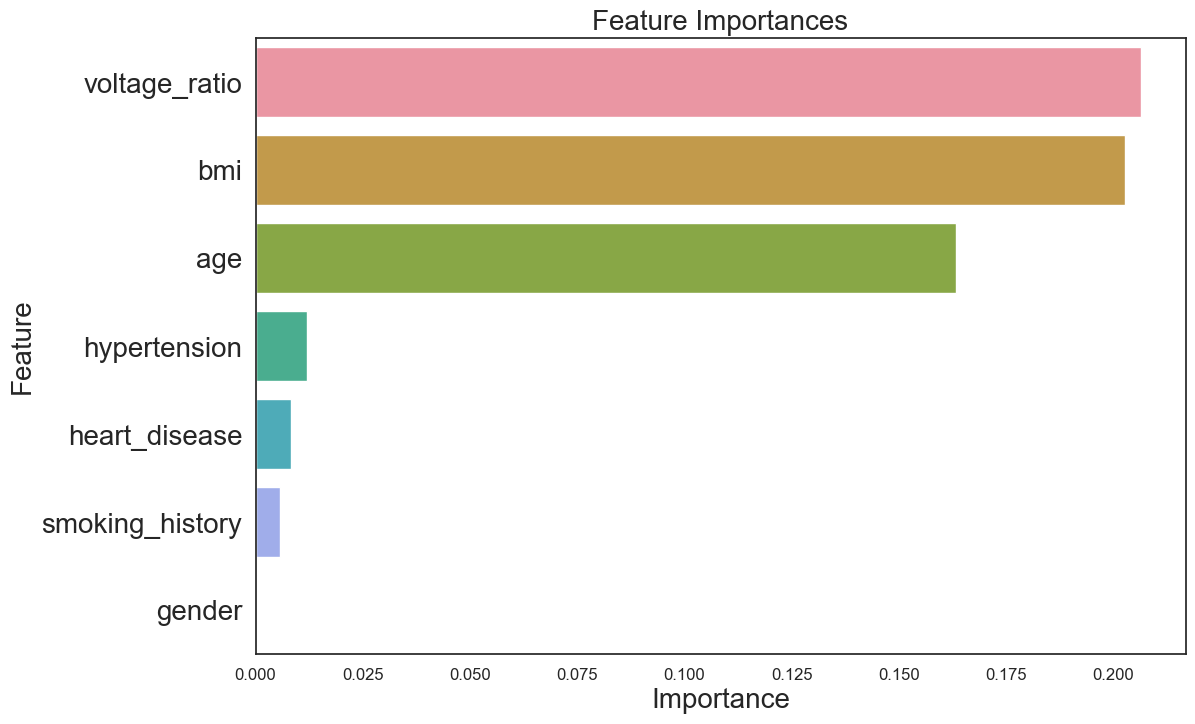

In [94]:
gini_attribute_gain = {key: gini_class - value for key, value in gini_attiribute.items()}

print(gini_attribute_gain)

gain_gini = {}
for item in sorted(gini_attribute_gain.items(), key=lambda item: item[1], reverse=True):
    gain_gini[item[0]] = item[1]

print(gain_gini)

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': gain_gini.keys(), 'Importance': gain_gini.values()})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Set font size for title
plt.title('Feature Importances', fontsize=20)

# Set font size for axis labels
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)

# Set font size for tick labels (optional)
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)

plt.show()

In [95]:
X = X[['voltage_ratio', 'bmi', 'age']]

In [96]:
X

voltage_ratio   bmi   age
0              54.86 27.32 30.00
1              72.80 32.53 37.00
2              71.42 17.85  1.56
3              71.42 49.74 54.00
4              59.00 23.95 52.00
...              ...   ...   ...
52582          34.16 29.82 72.00
52583          17.60 42.26 58.00
52584          52.10 34.49 80.00
52585          51.00 25.18 80.00
52586          28.64 25.69 57.02

[52587 rows x 3 columns]

**PCA**

In [97]:
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Explained Variance:
[1.50239844 0.82303098 0.67462763]
Total Explained Variance: 3.0001


In [98]:
# Explained variance
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

# Print results
print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance:.4f}")

explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

# Print results
print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")


Explained Variance Ratio:
[0.50078996 0.27433844 0.2248716 ]
Total Explained Variance Ratio: 1.0000


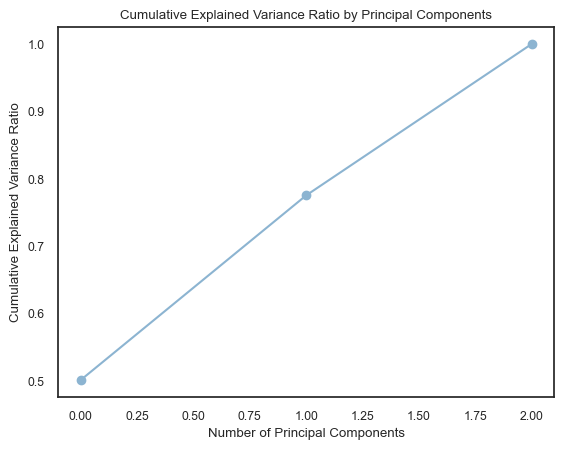

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Plot explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

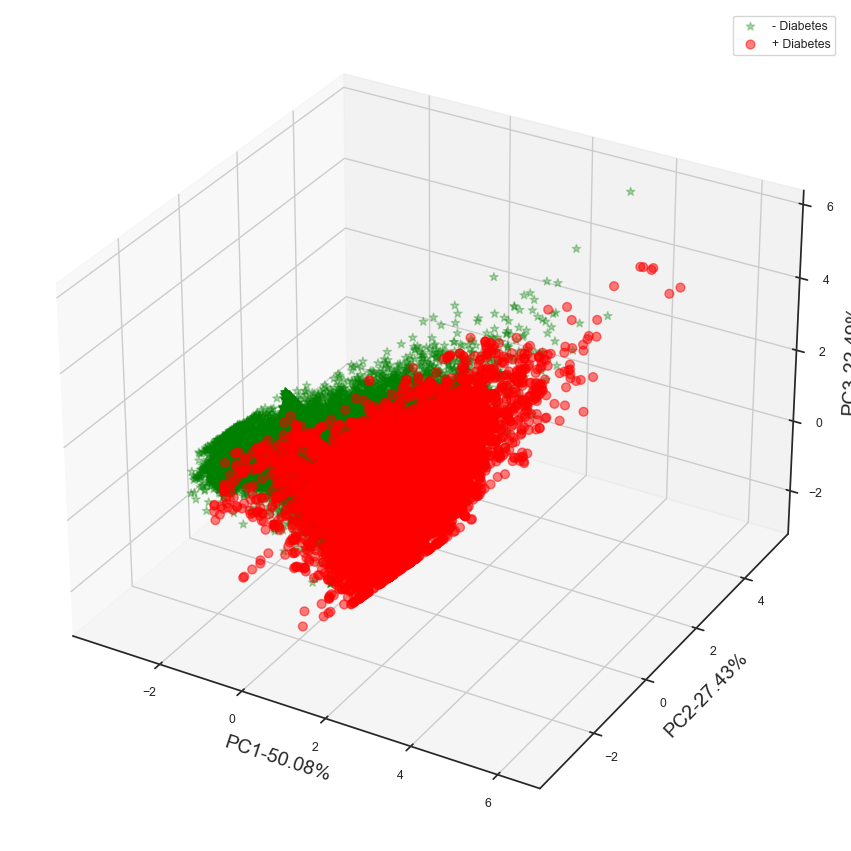

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt





pc1 = str(round((explained_variance_ratio[0]*100),2))
pc2 = str(round((explained_variance_ratio[1]*100),2))
pc3 = str(round((explained_variance_ratio[2]*100),2))

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

cdict = {0:'green',1:'red'}
labl = {0:'- Diabetes',1:'+ Diabetes'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(19.2,10.8))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("PC1-" + pc1 + "%", fontsize=14)
ax.set_ylabel("PC2-" + pc2 + "%", fontsize=14)
ax.set_zlabel("PC3-" + pc3 + "%", fontsize=14)

ax.legend()
plt.show()

In [101]:

from sklearn.decomposition import PCA


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_pca,
    labels=labels,
    dimensions=range(3),
    color=y
)
fig.update_traces(diagonal_visible=False)
fig.show()

**KLASIFIKASI**

In [102]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
# Data scaling
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)


RANDOM FOREST

In [103]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training accuracy: 0.9488934845135373
Model Accuracy:  0.8685111237877924
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6957
           1       0.83      0.76      0.80      3561

    accuracy                           0.87     10518
   macro avg       0.86      0.84      0.85     10518
weighted avg       0.87      0.87      0.87     10518



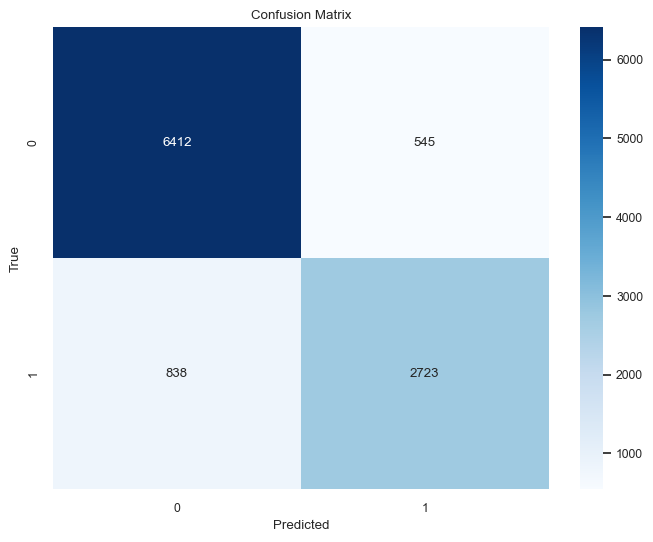

In [104]:
# Create Grid Search object
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)

# Split data into train and test sets


# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [105]:
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

precision:  0.8332313341493268
recall:  0.7646728447065431


         Feature  Importance
0  voltage_ratio        0.48
2            age        0.28
1            bmi        0.24


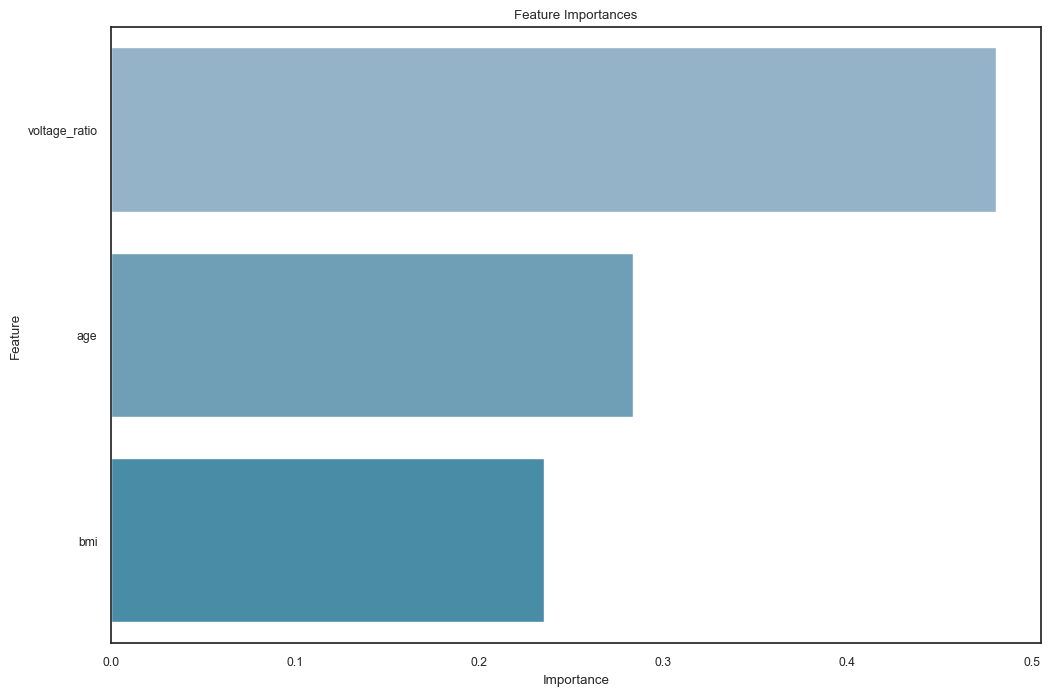

In [106]:
# Then we add the numeric feature names
feature_names = list(df_new[['voltage_ratio', 'bmi', 'age']])

# And now let's get the feature importances
importances = grid_search.best_estimator_.feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

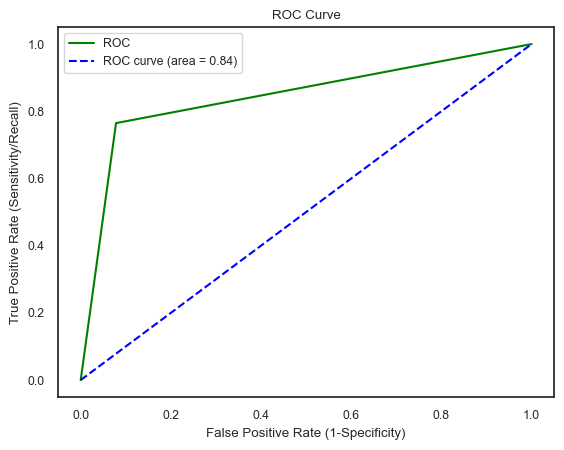

In [107]:
#PLOTTING GRAPH for model 1
#ROC curve


roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

LOGISTIC REGRESSION

In [109]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

Best Parameters:  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training accuracy: 0.8152321186621978
Model Accuracy:  0.8108956075299487
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6957
           1       0.76      0.64      0.70      3561

    accuracy                           0.81     10518
   macro avg       0.80      0.77      0.78     10518
weighted avg       0.81      0.81      0.81     10518



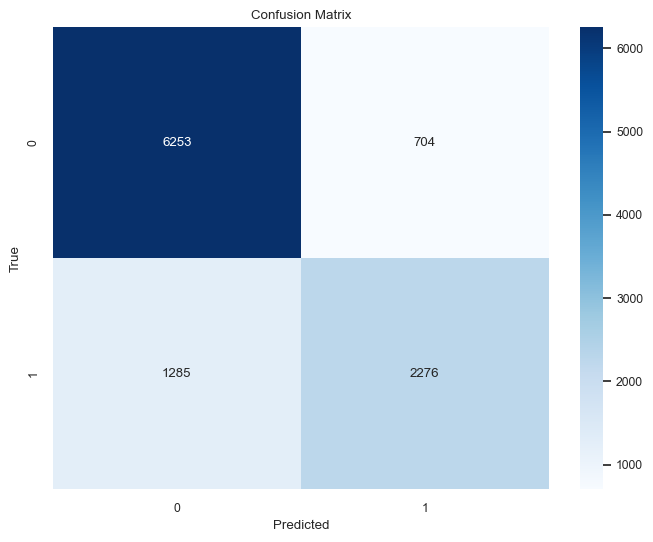

In [110]:
# Create Grid Search object
model = LogisticRegression()
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [111]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

precision:  0.763758389261745
recall:  0.6391463072170739


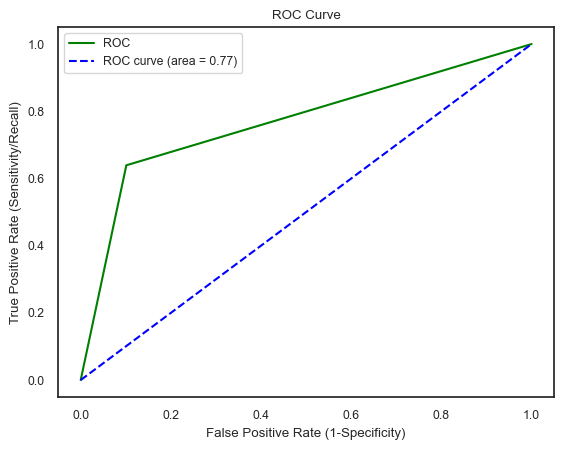

In [112]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

SUPPORT VECTOR MACHINE

In [113]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

In [114]:
# Create Grid Search object
model = SVC()
grid_search = GridSearchCV(model, param_grid, refit = True, verbose = 3)


# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.830 total time=  35.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.826 total time=  34.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.833 total time=  34.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.835 total time=  34.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.838 total time=  33.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=  34.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=  34.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.819 total time=  34.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.824 total time=  34.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.829 total time=  35.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.819 total time=  36.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

In [ ]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

LINEAR DISCRIMINANT ANALYSIS

In [ ]:
solvers = ['svd', 'lsqr', 'eigen']
grid = dict(solver=solvers)

In [ ]:
# Create Grid Search object
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search=GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1,error_score=0 )
grid_result=grid_search.fit(X_train, y_train)


# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

In [ ]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

MULTI-LAYER PERCEPTRON

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


grid_search = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train) # X is train samples and y is the corresponding labels


# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

In [ ]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()